In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt

import os
os.chdir('C:/BankRisk')

In [2]:
grp = 'FailRt'

#rtyp = "1q" # "1q" indicates quarterly fail rates (standard)
rtyp = "4q" # "4q" indicates rolling 4q fail rates (standard)

test = "_cboD"  ## denotes combo designation
vlst = ['Orig','Lags','Lags_sUE2']
#cbo = ['Orig','Lags','Lags_sUE2'] # combo tags (for use in charts)
#xvr = [['UE_4','HPI_4','CRE_4','UE2','sUE2'],['UE2','sUE2'],['UE2']]

if rtyp == "4q":
  rclst = ['FailRt4q']
  rskp = 3
elif rtyp == "1q":
  rclst = ['FailRt']
  rskp = 0
else:
  rclst = []
  rskp = 999  # force error if no specification

vofi = "FailRates_all2.csv"             ## history volumes file for groups to analyze
vo = pd.read_csv(vofi, index_col=0, parse_dates=True)
vo = vo.astype(float)

nmlst = ['CBfail']
dmlst = ['CBnbr']

nmz = dict(zip(rclst, nmlst))
dmz = dict(zip(rclst, dmlst))

#col names to use:
fv = "Fv"  # Fitted model volumes
bv = "Bv"  # Base scenario volumes
av = "Av"  # Adverse scenario volumes
sv = "Sv"  # SevAdv scenario volumes
fm = "Fit"  # these last 4 are model outputs for fitted model & 3 scenarios
bm = "Base"
am = "Adverse"
sm = "SevAdv"

dfz1 = []
dfz3 = []

In [3]:
vo = vo.ix[:'2014-09-30']  ## truncate dates after 12/31/2014 (since 2015 CCAR was created at end of 2014)
vo.tail()

CBfail   CBnbr    FailRt  FailRt4q
Date                                          
2013-09-30     6.0  5874.0  0.408580  0.453572
2013-12-31     2.0  5815.0  0.137575  0.389996
2014-03-31     5.0  5743.0  0.348250  0.411153
2014-06-30     5.0  5694.0  0.351247  0.311338
2014-09-30     1.0  5637.0  0.070960  0.227183

In [4]:
for yr in [2012,2013,2014,2015]:
  for mn in [1,3]:
    dttr = str(yr-1) + "-09-30"  # transition date (3rd qtr of year prior to CCAR year)
    dtst = str(yr-1) + "-12-31"  # start of 9q forecast period
    dten = str(yr+1) + "-12-31"  # end of 9q forecast period

    if mn == 1:
      mtyp = '_full'
    elif mn == 3:
      mtyp = '_3v'
    
    for suff in vlst:
    
      hdrw = [0,1] # indicates first 2 rows in forecast file "rtfi" have col headings
    
      rtfi = grp + "_" + str(yr) + mtyp + "_fcst_" + rtyp + '_' + suff + test + ".csv" ## file with modeled ccar forecast nco/fail rates
      rt = pd.read_csv(rtfi, index_col=0, header=hdrw, parse_dates=True)
      paramfi = grp + "_" + str(yr) + mtyp + "_param_" + rtyp + '_' + suff + test + ".csv"  ## param file for same run
    
      param = pd.read_csv(paramfi, index_col=0, header=0)
      param.index.name= 'scen'
    
      ### start prod loops here:
      balst= []
      dmlst = []
    
      for pr in np.arange(len(rt.columns.levels[0])):
        #pr = 2 # prod indexer
    
        drt = rt[rt.columns.levels[0][pr]]
        drt.reset_index(drop=False, inplace=True)
        drt.set_index('Date', inplace=True)
    
        if mn == 3:  ## 3var model
          prn = rt.columns.levels[0][pr][0:-1]
        else:        ## full model
          prn = rt.columns.levels[0][pr]
    
        df = vo[[nmz[prn],dmz[prn]]]
        df.columns = ['nco','bal']
        df.index.name = 'Date'
        df.reset_index(drop=False, inplace=True)
        df.set_index('Date',inplace=True)
    
        dfr = df.merge(drt, how='outer', left_index=True, right_index=True)
    
        # seed early rows of vol cols with actuals, then calc model vols for forecast periods:
        dfr['Bv'] = dfr['nco']
        dfr['Av'] = dfr['nco']
        dfr['Sv'] = dfr['nco']
    
        dfr['bal'] = dfr['bal'].fillna(method='pad')
        dfr[[bm,am,sm]] = dfr[[bm,am,sm]].fillna(-999)
    
        dfr.ix[dttr][bm] = -999
        for x in np.arange(len(dfr))[rskp:]:
          if dfr.ix[x][bm] == -999:
            dfr.ix[x][bv] = dfr.ix[x].nco
          else:
            if rtyp == "4q":
              dfr.ix[x][bv] = dfr.ix[x][bm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
                (dfr.ix[x-1][bv] +dfr.ix[x-2][bv] +dfr.ix[x-3][bv])
            else:
              dfr.ix[x][bv] = dfr.ix[x][bm] * dfr.ix[x].bal/400 
    
        dfr.ix[dttr][am] = -999
        for x in np.arange(len(dfr))[rskp:]:
          if dfr.ix[x][am] == -999:
            dfr.ix[x][av] = dfr.ix[x].nco
          else:
            if rtyp == "4q":
              dfr.ix[x][av] = dfr.ix[x][am] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
                (dfr.ix[x-1][av] +dfr.ix[x-2][av] +dfr.ix[x-3][av])
            else:
              dfr.ix[x][av] = dfr.ix[x][am] * dfr.ix[x].bal/400 
    
        dfr.ix[dttr][sm] = -999
        for x in np.arange(len(dfr))[rskp:]:
          if dfr.ix[x][sm] == -999:
            dfr.ix[x][sv] = dfr.ix[x].nco
          else:
            if rtyp == "4q":
              dfr.ix[x][sv] = dfr.ix[x][sm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
                (dfr.ix[x-1][sv] +dfr.ix[x-2][sv] +dfr.ix[x-3][sv])
            else:
              dfr.ix[x][sv] = dfr.ix[x][sm] * dfr.ix[x].bal/400 
    
        ## NEW SECTION:
        dfr.replace(to_replace=-999, value=np.nan, inplace=True)  ## replace -999 with nan
        for i in np.arange(len(dfr)):     ## remove forecast Adverse vol if there is no Adverse scenario
          if dfr.iloc[i].name >= pd.to_datetime(dtst):  ## check that this is a forecast period, not history
            if np.isnan(dfr.ix[i]['Adverse']):
              dfr.ix[i]['Av'] = np.nan
    
        dfv = dfr[['Bv','Av','Sv']].ix[dtst:dten].sum()  # 9q forecasts (ignore nco, Fv)
    
        r9q = pd.rolling_sum(dfr['2006-12-31':dtst]['nco'],window=9, min_periods=9)
        r9q = r9q.dropna()
        r9qm = r9q[r9q==r9q.max()]  # largest 9q losses in history
    
        dfv2 = pd.DataFrame(dfv, columns=[rt.columns.levels[0][pr]])
        dfv2.ix['ActMx'] = r9qm.values[0]
        dfv2.ix['DateMx'] = r9qm.index[0]
        dfv2t = dfv2.T
        dfv2t.reset_index(drop=False, inplace=True)
    
        b9q = pd.rolling_mean(dfr['2006-12-31':dtst]['bal'],window=9, min_periods=9)
        balst = balst + [b9q.ix[r9qm.index[0]]]  ## avg bal for max actual charge-offs
    
        dmlst = dmlst + [dfr['bal'].ix[dtst:dten].mean()]  ## avg bal during CCAR periods
        voldet = dfr.ix[str(yr-1)+'-01-01':]
        voldet.columns = pd.MultiIndex.from_product([[rt.columns.levels[0][pr]], list(voldet.columns)])
    
        if pr == 0:
          dfvr = dfv2t
          voldet2 = voldet.copy()
        else:
          dfvr = pd.concat([dfvr, dfv2t],ignore_index=True)
          voldet2 = voldet2.merge(voldet, how='left', left_index=True, right_index=True)
    
      if mn == 3:
        dfvr2 = dfvr.copy()
        dfvr2['bal'] = dmlst
        dfvr2['ActBalMx'] = balst
        dfvr2['rk']  = dfvr2.index % mn
        dfvr2['rk'] += 1
    
        dfvr2t = dfvr2.copy()
        dfvr2t['ActMxRt'] = dfvr2t['ActMx']*100/dfvr2t['ActBalMx']
        dfvr2t['ModRt'] = dfvr2t['Sv']*100/dfvr2t['bal']
        dfvr2t['rsq'] = param['r3']
        dfvr2t['Diff'] = dfvr2t['Sv'] - dfvr2t['Bv']
        dfvr2t['Desc'] = param['v1']+','+param['v2']+','+param['v3']+','+grp+"_"+str(yr) + mtyp + "_" + rtyp + '_' + suff+test
        dfvr2t = dfvr2t[['index', 'bal', 'Bv', 'Av', 'Sv', 'ActMx', 'ActBalMx', 'DateMx', 'ActMxRt', 'ModRt','rsq', 'Diff', 'Desc']]
        dfvr2t.to_csv(grp + "_" + str(yr) + mtyp + "_" + rtyp + '_' + suff + test + "_vol.csv")
        voldet2.to_csv(grp + "_" + str(yr) + mtyp + "_" + rtyp + '_' + suff + test + "_voldet.csv")
        if suff == vlst[0]:
          dfz3 = dfvr2t.copy()
        else:
          dfz3 = pd.concat([dfz3,dfvr2t], ignore_index=True)
    
      if mn == 1:
        dfvr['bal'] = dmlst
        dfvr['ActBalMx'] = balst
        dfvr[['Bv','Av','Sv','ActMx']] = dfvr[['Bv','Av','Sv','ActMx']].astype(float)
    
        dfvrt = dfvr.copy()
        dfvrt['ActMxRt'] = dfvrt['ActMx']*100/dfvrt['ActBalMx']
        dfvrt['ModRt'] = dfvrt['Sv']*100/dfvrt['bal']
        dfvrt['rsq'] = param.ix['rsq_adj'].values
        dfvrt['Diff'] = dfvrt['Sv'] - dfvrt['Bv']
        dfvrt['Desc'] = grp+"_"+str(yr) + mtyp + "_" + rtyp + '_' + suff + test
        dfvrt = dfvrt[['index', 'bal', 'Bv', 'Av', 'Sv', 'ActMx', 'ActBalMx', 'DateMx', 'ActMxRt', 'ModRt','rsq', 'Diff', 'Desc']]
        dfvrt.to_csv(grp + "_" + str(yr) + mtyp + "_" + rtyp + '_' + suff + test + "_vol.csv")
        voldet.to_csv(grp + "_" + str(yr) + mtyp + "_" + rtyp + '_' + suff + test + "_voldet.csv")
        if suff == vlst[0]:
          dfz1 = dfvrt.copy()
        else:
          dfz1 = pd.concat([dfz1,dfvrt],ignore_index=True)
    
    if mn == 3:
      if yr == 2012:
        df3_12 = dfz3.copy()
      elif yr == 2013:
        df3_13 = dfz3.copy()
      elif yr == 2014:
        df3_14 = dfz3.copy()
      elif yr == 2015:
        df3_15 = dfz3.copy()
        
    if mn == 1:
      if yr == 2012:
        df1_12 = dfz1.copy()
      elif yr == 2013:
        df1_13 = dfz1.copy()
      elif yr == 2014:
        df1_14 = dfz1.copy()
      elif yr == 2015:
        df1_15 = dfz1.copy()

In [5]:
str(yr) + mtyp

'2015_3v'

In [6]:
## stop until all years/mn combos are completed

In [7]:
df1t = pd.concat([df1_12, df1_13, df1_14, df1_15], ignore_index=True)
df3t = pd.concat([df3_12, df3_13, df3_14, df3_15], ignore_index=True)
dfzt = pd.concat([df1_12,df3_12,df1_13,df3_13,df1_14,df3_14,df1_15,df3_15], ignore_index=True)
df1t.to_csv(grp + "_allyr_" + rtyp + test + "_full_vol.csv")
df3t.to_csv(grp + "_allyr_" + rtyp + test + "_3v_vol.csv")
dfzt.to_csv(grp + "_allyr_" + rtyp + test + "_full3v_vol.csv")
dfzt.tail()

index     bal       Bv       Av       Sv ActMx     ActBalMx  \
43  FailRt4q1  5637.0 -17.3838  167.849  221.831   282  6705.333333   
44  FailRt4q2  5637.0 -53.8159  147.448  215.892   282  6705.333333   
45  FailRt4q0  5637.0 -3.49468  57.8778  205.399   282  6705.333333   
46  FailRt4q1  5637.0 -16.6649  132.787  217.627   282  6705.333333   
47  FailRt4q2  5637.0  7.91283  57.5323  220.014   282  6705.333333   

                 DateMx  ActMxRt    ModRt       rsq     Diff  \
43  2011-03-31 00:00:00  4.20561  3.93527  0.928687  239.215   
44  2011-03-31 00:00:00  4.20561  3.82991  0.928431  269.708   
45  2011-03-31 00:00:00  4.20561  3.64376  0.966390  208.893   
46  2011-03-31 00:00:00  4.20561  3.86069  0.950633  234.292   
47  2011-03-31 00:00:00  4.20561  3.90303  0.939436  212.101   

                                                Desc  
43           UE,T3m,UE_4,FailRt_2015_3v_4q_Lags_cboD  
44        UE,Prime,CRE_4,FailRt_2015_3v_4q_Lags_cboD  
45     sUE2,UE,UE_4,FailRt_2015_3v_4q_Lags_sUE2_cboD  
46  sUE2,Prime,UE_4,FailRt_2015_3v_4q_Lags_sUE2_cboD  
47      sUE2,UE,BBB,FailRt_2015_3v_4q_Lags_sUE2_cboD

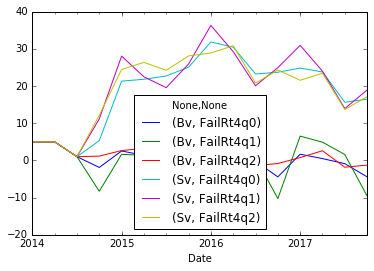

In [8]:
voldet2.swaplevel(0, 1, axis=1)[['Bv','Sv']].plot()

In [9]:
grp + "_allyr_" + rtyp + test

'FailRt_allyr_4q_cboD'